# Bank-BERT using Hugging Face

### Import Necessary Libraries
This cell imports necessary Python libraries required for data processing, machine learning model training, and visualization.


In [1]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
import pickle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


2024-04-22 22:39:48.552181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 22:39:48.552275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 22:39:48.680997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load and Preprocess the Dataset
Here, we load the transaction data from a CSV file and preprocess it by filtering out unwanted entries and converting descriptions to lowercase to match the expected input format of the BERT model.


In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/no-negative-transactions/amex_all_categorized_raw.csv')
df = df[df['Description'] != 'Description']

# Convert descriptions to lowercase
df['Description'] = df['Description'].str.lower()


### Visualizing the dataset

Visualizing the dataset to see all classes. 

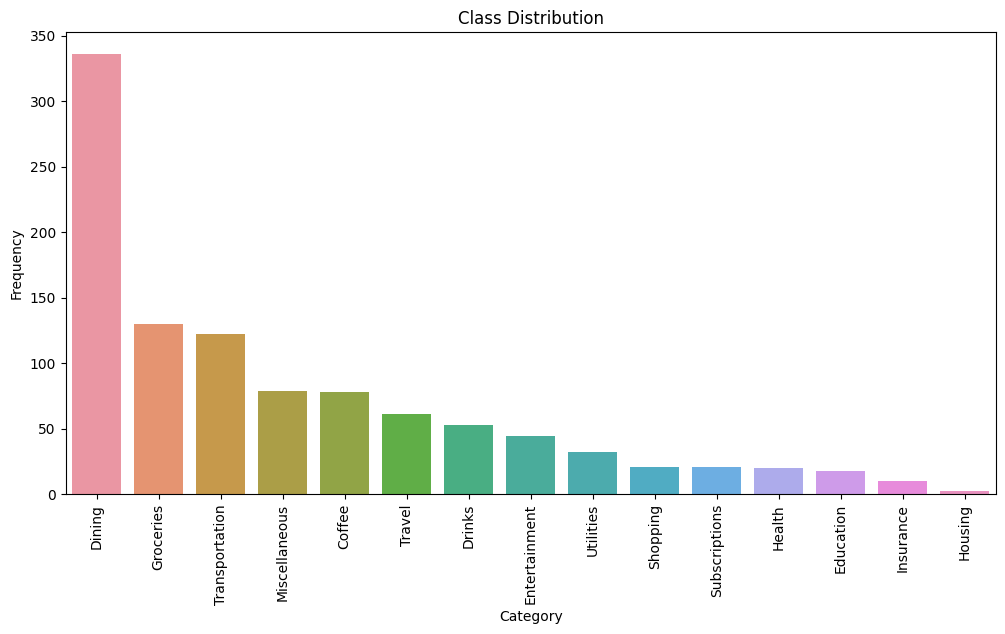

In [5]:
# Visualizing class distribution
plt.figure(figsize=(12, 6))
class_counts = df['Category'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.show()

### Encode Transaction Categories
This cell uses `LabelEncoder` to transform categorical labels into a format suitable for model training. The encoder is then saved for later use to decode predicted labels.


In [6]:
# Encode categories
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])

# Save the label encoder for later use
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


### Tokenization
Initialize the BERT tokenizer and apply it to the transaction descriptions to prepare inputs for the BERT model. This step converts text data into a format that can be processed by the model.


In [7]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function that operates on a single text item
def tokenize_function(description):
    return tokenizer(description, padding="max_length", truncation=True, max_length=64)

# Apply the tokenization to the entire dataframe
tokenized_data = df['Description'].apply(tokenize_function)
df['input_ids'] = tokenized_data.apply(lambda x: x['input_ids'])
df['attention_mask'] = tokenized_data.apply(lambda x: x['attention_mask'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Define a Custom Dataset
Define a custom PyTorch dataset class, `AmexDataset`, which formats the input and labels correctly for training the BERT model.


In [8]:
# Define a custom dataset
class AmexDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


### Split the Dataset
This cell splits the dataset into training and testing subsets to ensure robust model evaluation. The split is stratified to maintain the distribution of categories across the datasets.



In [9]:
# Split dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Category_encoded'])

train_dataset = AmexDataset({'input_ids': list(train_df['input_ids']), 'attention_mask': list(train_df['attention_mask'])}, train_df['Category_encoded'].tolist())
test_dataset = AmexDataset({'input_ids': list(test_df['input_ids']), 'attention_mask': list(test_df['attention_mask'])}, test_df['Category_encoded'].tolist())


## Naive Deep Learning Method

For the naive deep learning method, we will use a simple non-fine tuned BERT-BASE model.

### Initialize and Evaluate Model Before Training 
Initialize the BERT model for sequence classification with the number of unique categories as labels. Optionally, you can perform a pre-training evaluation to establish a baseline performance, but typically the model is evaluated after training.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


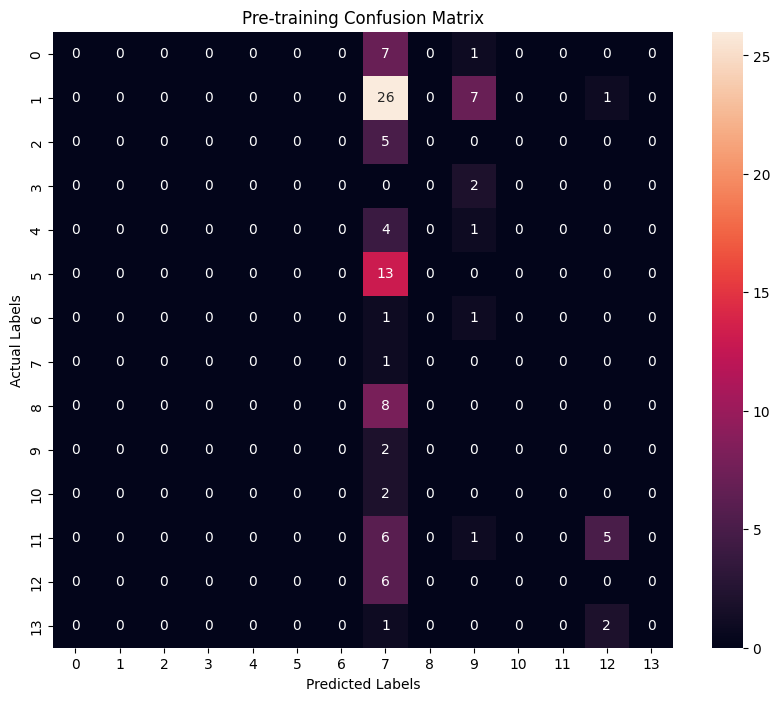

Pre-training Evaluation
Precision: 0.0001, Recall: 0.0097, F1 Score: 0.0002, Accuracy: 0.0097


In [10]:
# Initialize model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['Category'].unique()))

# Pre-training evaluation
def evaluate_pretrained_model(model, dataloader, label_encoder):
    classification_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predictions = [classification_pipeline(description)[0]['label'] for description in test_df['Description']]
    predicted_labels = [int(label.split('_')[-1]) for label in predictions]
    true_labels = test_df['Category_encoded'].tolist()

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Pre-training Confusion Matrix")
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    return precision, recall, f1, accuracy

pre_precision, pre_recall, pre_f1, pre_accuracy = evaluate_pretrained_model(model, test_dataset, label_encoder)
print("Pre-training Evaluation")
print(f"Precision: {pre_precision:.4f}, Recall: {pre_recall:.4f}, F1 Score: {pre_f1:.4f}, Accuracy: {pre_accuracy:.4f}")


## Advanced Deep Learning Method

For the advanced deep learning method we will fine-tune the BERT-BASE model to the bank statement dataset

### Train and Evaluate the Model

In this Jupyter notebook, we fine-tune a pre-trained BERT model from Hugging Face's `transformers` library to classify financial transaction descriptions. This process involves adapting all layers of the BERT model, previously trained on a vast general-language corpus, to our specific dataset using the `Trainer` API. This API facilitates the fine-tuning by managing training dynamics such as the learning rate, epochs, and batch size with the AdamW optimizer and a learning rate scheduler. The fine-tuning adjusts the model's pre-trained linguistic representations to the nuances of transaction text, enhancing its predictive accuracy on our specialized task.

This cell sets up the training arguments and initializes a Trainer to train the BERT model. After training, we perform a post-training evaluation to assess the improvements.


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
10,2.867200
20,2.885700
30,2.808700
40,2.657100
50,2.742500
60,2.638100
70,2.679200
80,2.594700
90,2.441000
100,2.279700


Post-training Evaluation
Precision: 0.8553, Recall: 0.8447, F1 Score: 0.8330, Accuracy: 0.8447


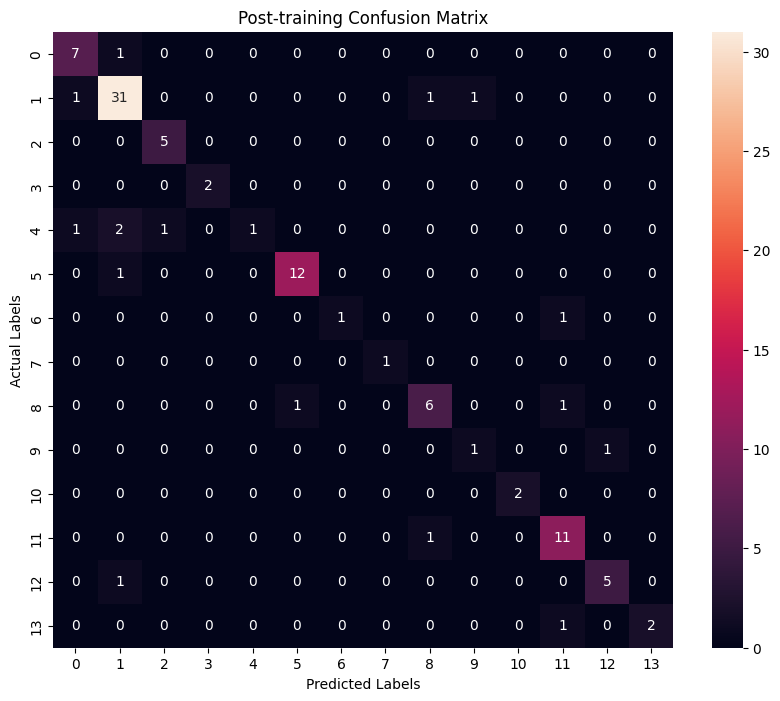

In [11]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train and evaluate model
trainer.train()
results = trainer.evaluate()

# Post-training evaluation
classification_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
test_predictions = [classification_pipeline(description)[0]['label'] for description in test_df['Description']]
predicted_labels = [int(label.split('_')[-1]) for label in test_predictions]

post_precision, post_recall, post_f1, post_accuracy = precision_recall_fscore_support(test_df['Category_encoded'], predicted_labels, average='weighted')
post_accuracy = accuracy_score(test_df['Category_encoded'], predicted_labels)

# Display metrics and confusion matrix
print("Post-training Evaluation")
print(f"Precision: {post_precision:.4f}, Recall: {post_recall:.4f}, F1 Score: {post_f1:.4f}, Accuracy: {post_accuracy:.4f}")

conf_matrix = confusion_matrix(test_df['Category_encoded'], predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Post-training Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


### Save the Trained Model and Tokenizer
This cell saves the trained model and tokenizer to the specified directory for future use, such as in deployment or further evaluation.


In [15]:
# Save model and tokenizer
model_path = "/kaggle/working/BERT_amex_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# Optionally, push to the hub
model.push_to_hub("mrinoyb2/bankbert", token=huggingface_api_key)
tokenizer.push_to_hub("mrinoyb2/bankbert", token=huggingface_api_key)

print("Training complete")
print("Evaluation results:", results)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Training complete
Evaluation results: {'eval_loss': 0.9214252233505249, 'eval_runtime': 0.2143, 'eval_samples_per_second': 480.587, 'eval_steps_per_second': 32.661, 'epoch': 15.0}
